In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [3]:
incept3=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
for layers in incept3.layers:
    layers.trainable=False

87924736/87910968 [==============================] - 0s 0us/step


In [4]:
last_layer=incept3.get_layer('mixed10')
last_output = last_layer.output

In [5]:
from keras.layers import Dropout
x=Flatten()(last_output)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model3=Model(incept3.input,x)
from tensorflow.keras.optimizers import Adam
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) 
val_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Bitirme/gogus x-ray_bitirme projesi/xray/train',
                                                 target_size = (180, 180),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

Found 5200 images belonging to 2 classes.


In [10]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Bitirme/gogus x-ray_bitirme projesi/xray/test',
                                            target_size = (180, 180),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

val_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Bitirme/gogus x-ray_bitirme projesi/xray/val',
                                            target_size = (180, 180),
                                            batch_size = 64,
                                            shuffle=False,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience =  4 , verbose=1,factor=0.01, min_lr=0.0001)
callbacks_list = [ early, learning_rate_reduction]

In [12]:
r3=model3.fit(training_set,validation_data=val_set,epochs=10,verbose=2,callbacks=callbacks_list)

Epoch 1/10
82/82 - 1190s - loss: 4.1102 - accuracy: 0.7962 - val_loss: 0.2745 - val_accuracy: 0.9000 - lr: 0.0010 - 1190s/epoch - 15s/step
Epoch 2/10
82/82 - 93s - loss: 0.3787 - accuracy: 0.8671 - val_loss: 0.2888 - val_accuracy: 0.9167 - lr: 0.0010 - 93s/epoch - 1s/step
Epoch 3/10
82/82 - 93s - loss: 0.2655 - accuracy: 0.9012 - val_loss: 0.2429 - val_accuracy: 0.9167 - lr: 0.0010 - 93s/epoch - 1s/step
Epoch 4/10
82/82 - 93s - loss: 0.2214 - accuracy: 0.9146 - val_loss: 0.2170 - val_accuracy: 0.9167 - lr: 0.0010 - 93s/epoch - 1s/step
Epoch 5/10
82/82 - 93s - loss: 0.2013 - accuracy: 0.9212 - val_loss: 0.2481 - val_accuracy: 0.9167 - lr: 0.0010 - 93s/epoch - 1s/step
Epoch 6/10
82/82 - 93s - loss: 0.1916 - accuracy: 0.9290 - val_loss: 0.2669 - val_accuracy: 0.9000 - lr: 0.0010 - 93s/epoch - 1s/step
Epoch 7/10
82/82 - 93s - loss: 0.1708 - accuracy: 0.9340 - val_loss: 0.2260 - val_accuracy: 0.9167 - lr: 0.0010 - 93s/epoch - 1s/step
Epoch 8/10
82/82 - 93s - loss: 0.1674 - accuracy: 0.9325 

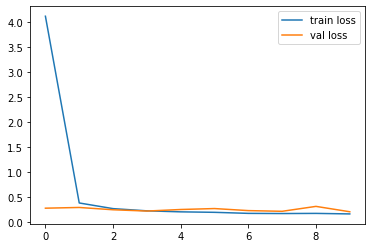

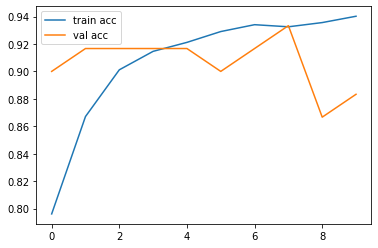

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r3.history['accuracy'], label='train acc')
plt.plot(r3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [14]:
model3.evaluate(test_set)

10/10 [==============================] - 439s 49s/step - loss: 0.3000 - accuracy: 0.8974


[0.30000561475753784, 0.8974359035491943]

In [15]:
preds = model3.predict(test_set,verbose=1)

10/10 [==============================] - 7s 564ms/step


In [16]:
predictions = preds.copy()
predictions[predictions <= 0.75] = 0
predictions[predictions > 0.75] = 1

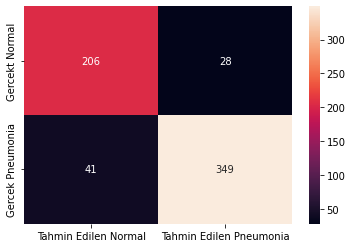

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Gercekt Normal", "Gercek Pneumonia"],
                  columns=["Tahmin Edilen Normal", "Tahmin Edilen Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [18]:
 print(classification_report(y_true=test_set.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.83      0.88      0.86       234
   PNEUMONIA       0.93      0.89      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.88       624
weighted avg       0.89      0.89      0.89       624



In [ ]:
model3.save('Ilk_model.h5') 